# **Use Google Colab for faster model training**

In [0]:
# Mount google drive

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Unzip the datasets. Change the paths to your location.
!unzip gdrive/My\ Drive/emoticon/data_cropped.zip
!unzip gdrive/My\ Drive/emoticon/test.zip

In [4]:
# Install triplpet loss
!pip install online_triplet_loss

In [0]:
# import libraries
import torch.cuda
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import csv
from PIL import Image
import IPython.display as ipd
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import logging
from online_triplet_loss.losses import *

CUDA_LAUNCH_BLOCKING="1"

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
BATCH_SIZE = 64
random_seed= 42

In [0]:
#Training path
FOLDER_DATASET = "data_cropped/"
tracks_labels = "data_cropped/labels.csv" #File containing images' path and labels

#Testing path
FOLDER_DATASET_TEST = "test/"
tracks_labels_test = "test/test_labels.csv" #File containing images' path and labels

In [0]:
# Class for loading dataset

class Data(Dataset):
    def __init__(self, folder_dataset, label_file, transform = None):
        self.features = []
        self.labels = []
        self.transform = transform
        
        with open(label_file) as f:
            reader = csv.reader(f, delimiter=',')
            for line in reader:
                #Image path
                self.features.append(folder_dataset + line[0])
                #labels
                self.labels.append(np.int32(line[1]))

        
                
    #override to give pytorch access to any image
    def __getitem__(self,index):
        img = Image.open(self.features[index])
        img = img.convert('RGB')
        img = img.resize((224,224))
        if self.transform is not None:
            img = self.transform(img)
        
        # Convert image and label to torch tensors
        img = torch.from_numpy(np.asarray(img))
        label = torch.from_numpy(np.asarray(self.labels[index]))
        return img, label
    
    # Override to give PyTorch size of dataset
    def __len__(self):
        return len(self.labels)

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])
dset_train = Data(FOLDER_DATASET, tracks_labels,  transform)
dataset_train = DataLoader(dset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

dset_test = Data(FOLDER_DATASET_TEST, tracks_labels_test, transform)
dataset_test = DataLoader(dset_test, batch_size=1, shuffle=False, num_workers=1)

In [11]:
resnet = torchvision.models.resnet50(pretrained=True)

# Freeze the layers of resnet model
for param in resnet.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
# new final layer with 128 vector
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 128)
resnet = resnet.to(device)

In [0]:
import torch.optim as optim
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.0001, momentum=0.9)

In [0]:
# Empty lists to store training loss and test accuracy
train_losses = []
test_accs = []

In [0]:
def create_db():
  """
  Create the database with images from training dataset and save the 128 vector embedding for each image.
  emotion_0.png = label 0 (laughing)
  emotion_1.png = label 1 (love)
  emotion_2.png = label 2 (laughing)
  emotion_3.png = label 3 (Mind-Blown)
  emotion_4.png = label 4 (Amazed)
  emotion_5.png = label 5 (Sad)

  """
  db = []

  for i in range(0, 6):
    img = Image.open("data_cropped/emotion_" + str(i) + ".png")
    img = img.convert('RGB')
    img = img.resize((224,224))
    #         print("image shape : ", img.size)
    img = transform(img)
    img = img.view(1, 3, 224, 224)
    test_out = resnet(img.to(device))

    db.append(test_out)

  return db

In [16]:
n_epoch = 50

valid_loss_min = np.Inf

for epoch in range(1, n_epoch + 1):
    
    train_loss = 0.0
    
    # Start training
    resnet.train()
    for data,target in dataset_train:
        
        data = data.to(device)
        target = target.to(device)  
        optimizer.zero_grad()
        outputs = resnet(data)

        # Create triplets and calculate triplet loss
        loss = batch_hard_triplet_loss(target, outputs, margin=2, device='cuda')
        loss.backward()
        train_loss += loss.cpu().item()

        optimizer.step()
        _, prediction = torch.max(outputs.data, 1)
   
    train_loss = train_loss/len(dataset_train)

    # Add to list to plot the loss chart   
    train_losses.append(train_loss)

    print('\n\nEpoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))


    # Create DB
    db = create_db()

    test_acc = 0
    resnet.eval()
    for data, target in dataset_test:
        
        data = data.to(device)
        output = resnet(data)
        
        distances = []

        for i in range(6):
          # Euclidean distance
          dist = torch.sqrt(torch.pow(output - db[i],2).sum(dim=1))
          distances.append(dist)

        # Get the index of that image which has minimum euclidean distance.        
        index = distances.index(min(distances))

        if target == index:
          test_acc += 1

    test_acc = test_acc/len(dataset_test.dataset)

    print('Epoch: {} \tTest Accuracy: {:.6f}'.format(
        epoch, test_acc))
    
    test_accs.append(test_acc)
    



Epoch: 1 	Training Loss: 2.405069
Epoch: 1 	Test Accuracy: 0.428571


Epoch: 2 	Training Loss: 2.333082
Epoch: 2 	Test Accuracy: 0.452381


Epoch: 3 	Training Loss: 2.238603
Epoch: 3 	Test Accuracy: 0.500000


Epoch: 4 	Training Loss: 2.107782
Epoch: 4 	Test Accuracy: 0.523810


Epoch: 5 	Training Loss: 2.008163
Epoch: 5 	Test Accuracy: 0.571429


Epoch: 6 	Training Loss: 1.913656
Epoch: 6 	Test Accuracy: 0.619048


Epoch: 7 	Training Loss: 1.800403
Epoch: 7 	Test Accuracy: 0.642857


Epoch: 8 	Training Loss: 1.690839
Epoch: 8 	Test Accuracy: 0.642857


Epoch: 9 	Training Loss: 1.603296
Epoch: 9 	Test Accuracy: 0.666667


Epoch: 10 	Training Loss: 1.506870
Epoch: 10 	Test Accuracy: 0.738095


Epoch: 11 	Training Loss: 1.406963
Epoch: 11 	Test Accuracy: 0.738095


Epoch: 12 	Training Loss: 1.313421
Epoch: 12 	Test Accuracy: 0.785714


Epoch: 13 	Training Loss: 1.226007
Epoch: 13 	Test Accuracy: 0.833333


Epoch: 14 	Training Loss: 1.142003
Epoch: 14 	Test Accuracy: 0.857143


Epoch: 1

In [0]:
import matplotlib.pyplot as plt

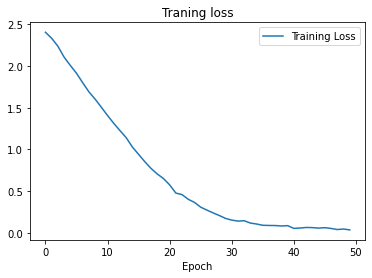

In [21]:
plt.plot(train_losses, label = "Training Loss") 
plt.xlabel('Epoch') 
plt.title('Traning loss') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show()

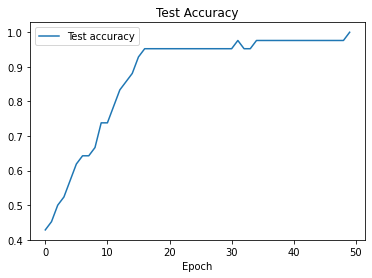

In [22]:
plt.plot(test_accs, label = "Test accuracy") 
plt.xlabel('Epoch') 
plt.title('Test Accuracy') 
  
# show a legend on the plot 
plt.legend() 
  
# function to show the plot 
plt.show()